# CutMix 또는 Mixup 비교

In [ ]:
!pip install --upgrade tensorflow=='2.6.0'
!pip install --upgrade numpy==''

In [ ]:
!pip uninstall keras
!pip install keras==2.6.0

In [ ]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

In [ ]:
# TensorFlow and tf.keras
from tensorflow import keras

# Helper libraries
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

### 1. 데이터 불러오기

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

### 2. Augmentation을 적용한 데이터셋 만들기

In [ ]:
# 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

    def 전처리_함수(image, label):   # 변환할 이미지와 라벨
        # 이미지 변환 로직 적용
        new_image = 이미지_변환(image)
        return new_image, label

    tf.cast = type 변경
    tf.cast(
    x, dtype, name=None
    )


이렇게 되면 이미지 변환의 결과로 리턴 받은 이미지를 그다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 된다. 위에서 만든 기본적인 전처리 함수도 위와 같은 구조를 가지고 있다. 이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224,224) 사이즈로 resize한다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것이다.

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

random_flip_left_right()과 random_brightness()를 활용하겠다. 'flip'의 경우 좌우 대칭을 해준다. 예컨대 이미지 분류 문제에서 개이미지는 좌우를 대칭하더라도 문제가 생기지 않는다. 따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있도록 한다. 또 'brightness'를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 하겠다.

#### 원 핫 인코딩(one-hot incoding)

In [ ]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

원핫 인코딩은 딥러닝 과정에서 loss 함수 계산을 용이하게 해주어 학습의 효율을 증가시킬 수 있고, 범주형 변수를 머신러닝에 사용가능하게 만들어주는 방법이다.

10장의 강아지, 고양이, 여우, 호랑이 사진들과 목록이 있다고 할 때, 이를 단일 벡터로 만든 경우와, 원핫 인코딩으로 표현한 결과는 아래 그림처럼 요약이 가능하다.

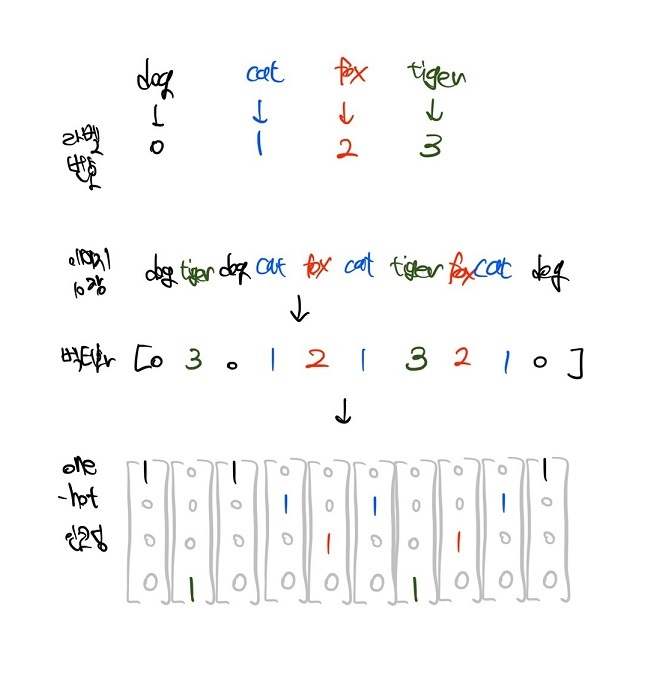

원한 인코딩이란 이처럼 [0,3,0,1,2..] 이라는 각 라벨에 해당하는 인덱스를 해당 위치만 1로 매핑하고, 나머지는 0으로 매핑한 벡터로 표현하는 방법

두개의 사진을 붙일 때, 해당 영역을 각 레이블 값으로 인식시켜주기 위한 방법이다.

이제 필요한 전처리는 끝났다. 이미지를 상황에 맞게 전처리 되는 함수를 적용해 보자.

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### CutMix

#### 논문

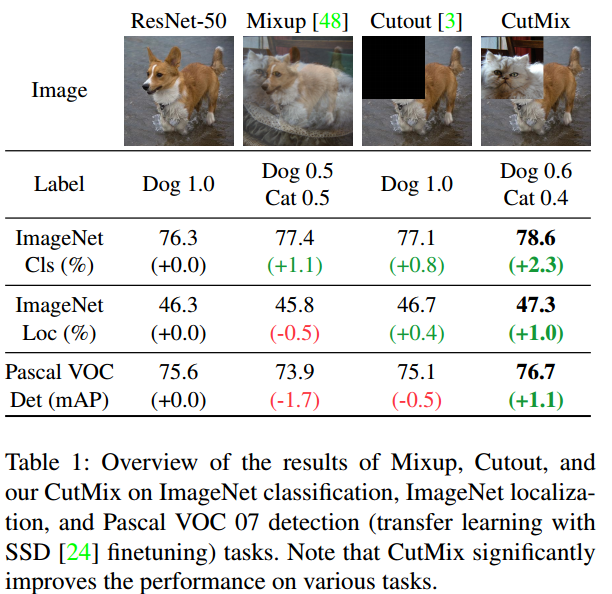

CutMix는 classification, localization, detection 세가지 task에 좋은 성능을 나타내고 있다.

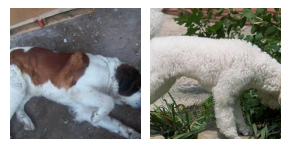

CutMix는 이미지의 부분 영역을 다른 이미지의 부분영역으로 대체한다.

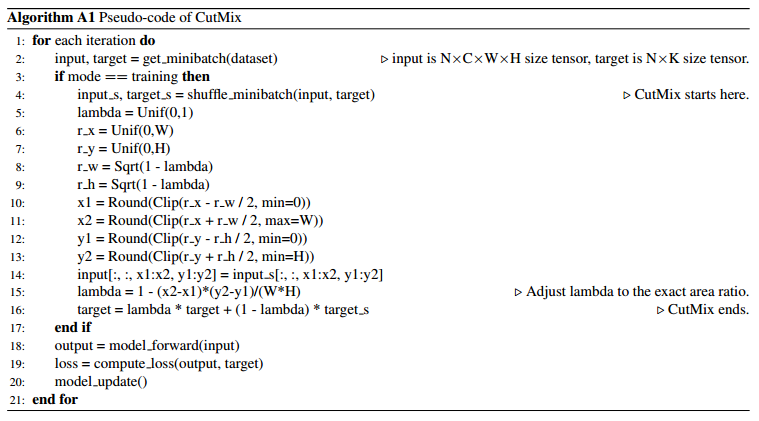

CutMix는 우선 두개의 이미지를 선택한다. 그 이후에 람다를 균일 분포(0,1)에서 sample한다. 람다는 부분 영역과 전체 영역의 비율을 조절하는 파라미터이다.

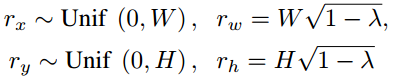

이미지의 부분 영역 (r_x, r_y, r_w, r_h)을 선택하기 위해 r_x와 r_y는 균일 분포(0,W), (0,H)에서 sample한다. r_w와 r_h는 위의 람다와 관련된 식으로 계산한다.

하나의 이미지에서 계산된 부분 영역은 제거하고, 제거된 영역을 다른 이미지의 부분 영역으로 대체한다. 그리고 람다를 아래 식으로 다시 계산한다.

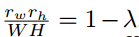

다시 계산한 람다를 target label을 조정하는데 사용한다.

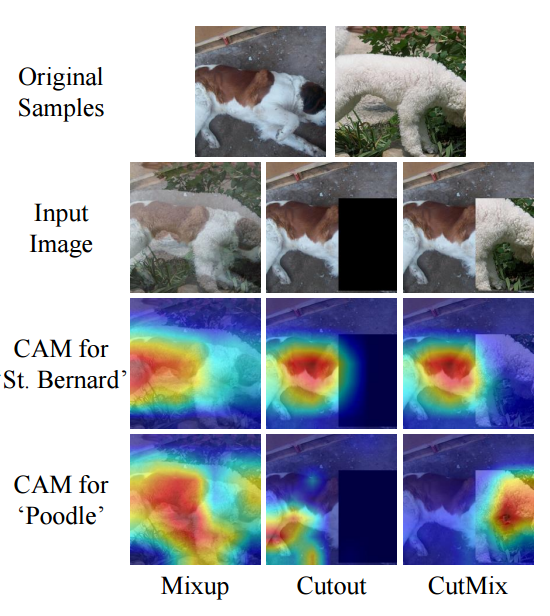

CutMix로 생성한 이미지로 학습한 신경망을 CAM으로 확인한 결과이다. 모델이 이미지의 특정 부분만을 보고 판단하는 것이 아니라 전체적인 영역을 보고 판단한다.

#### 구현

##### 이미지 섞기

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True, # return 값을 dict이 아닌 tuple로 저장
    shuffle_files=True,
    with_info=True,
)

In [ ]:
num_classes = ds_info.features["label"].num_classes # label의 개수
ds_train = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_test = apply_normalize_on_dataset(ds_test, with_aug=False)

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

두 개의 이미지를 얻었다.

이 중 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 보자.

이번 실험에서는 이미지 a,b가 모두 (224,224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠다.

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

바탕 이미지 image_a에 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해보자.

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

성공적으로 강아지 두 마리가 합쳐진 것을 알 수 있다.

사뭇보면 오른쪽 밑 강아지는 강아지라고 인식 못하지 않을까 싶지만, 위에서 한 원-핫 인코딩으로 인식할 수 있다. 또한, 밑 강아지는 이 부분을 제외하고는 공백이었기 때문에, 사진 속 강아지를 인식 잘 하고 합성을 했다고 볼 수 있다.

##### 라벨 섞기

이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 한다.

CutMix에서는 면적에 비례해서 라벨을 섞어준다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두가지 라벨의 비율로 더해준다. 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해준다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용한다.

위에서 섞인 이미지 두가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해보자.

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

위에서 구현한 두함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 보자.

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### 훈련

##### resnet50

In [ ]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

##### aug_resnet50

In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 데이터
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
# 일반 데이터 모델

EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
# CutMix가 적용된 모델

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = aug_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

#### 시각화

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With CutMix'], loc='upper left')
plt.show()

조금 더 확대해 보자.

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

처음에는 비슷했지만, epoch 8시점 부터, CutMix가 성능이 더 좋다는 것을 볼 수 있다.

데이터 갯수를 주고 임의로 노이즈를 준 CutMix는 논문에서 말한 것처럼 성능을 더 높여주는 역활을 한 것을 알 수 있었다.

### Mixup

https://arxiv.org/abs/1710.09412

Mixup은 앞에서 구현한 CutMix보다 간단하게 이미지와 라벨을 섞어준다. 참고자료는 앞에서 본 CutMix 비교표에서 Mixup이라는 방법이 제안된 논문이다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있다.

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 된다.

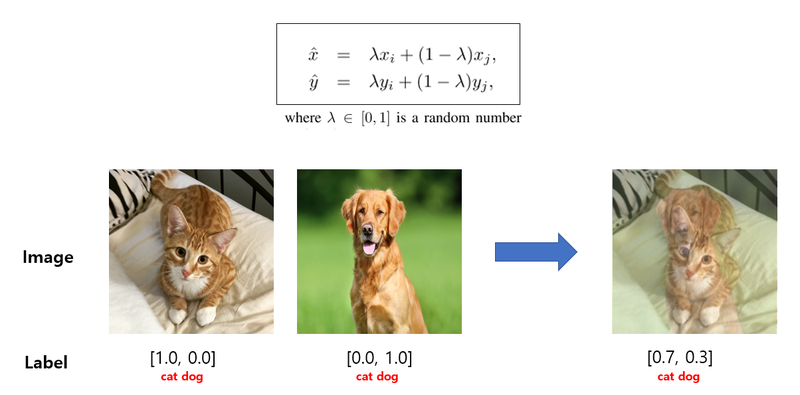

#### 구현

##### 이미지 섞기


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True, # return 값을 dict이 아닌 tuple로 저장
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes # label의 개수

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

##### 함수 

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

#### 훈련

In [ ]:
# 데이터
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
# Mixup이 적용된 모델

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = aug_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

#### 시각화

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With MixUp'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

확실히 MixUp이 기본보다 더 성능이 높다.

# 세가지 비교

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

미세하지만 MixUp이 더 정확성이 높다는 것을 알 수 있다.

### 참고

https://deep-learning-study.tistory.com/633

https://teddylee777.github.io/tensorflow/tfds-datasets

https://jimmy-ai.tistory.com/100

# 회고

이미지 데이터를 성능을 높이기 위해 만들어주다니..

노이즈를 많이 제거하는 방법만 배웠는데, 필요에 따라 만들어주기도 하다니 신기하다.